# Gap-filling with CNN

**Author:** Yifei Hang (UW Varanasi intern 2024)


This notebook shows how to fit a basic Convolutional Neural Network for filling the gaps in the Chlorophyll-a data. Although you can run this tutorial on CPU, it will be much faster on GPU. We used the image `quay.io/pangeo/ml-notebook:2024.08.18` for running the notebook.

In [5]:
import xarray as xr
import numpy as np

import dask.array as da

import matplotlib.pyplot as plt

import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import ConvLSTM2D, BatchNormalization, Conv2D, Dropout

In [6]:
# list all the physical devices
physical_devices = tf.config.list_physical_devices()
print("All Physical Devices:", physical_devices)

# list all the available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Print infomation for available GPU if there exists any
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print("GPU Details:", details)
else:
    print("No GPU available")

All Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Details: {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


2024-08-21 01:07:44.661600: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-21 01:07:44.720010: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-21 01:07:44.720279: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
zarr_ds = xr.open_zarr("~/shared-public/mind_the_chl_gap/IO.zarr")
zarr_sliced = zarr_ds.sel(lat=slice(35, -5), lon=slice(45,90))
all_nan_CHL = np.isnan(zarr_sliced["CHL_cmes-level3"]).all(dim=["lon", "lat"]).compute()  # find sample indices where CHL is NaN
zarr_CHL = zarr_sliced.sel(time=(all_nan_CHL == False))  # select samples with CHL not NaN
zarr_CHL = zarr_CHL.sortby('time')
zarr_CHL = zarr_CHL.sel(time=slice('2020-01-01', '2020-12-31'))
zarr_CHL

<xarray.Dataset> Size: 958MB
Dimensions:                       (time: 366, lat: 149, lon: 181)
Coordinates:
  * lat                           (lat) float32 596B 32.0 31.75 ... -4.75 -5.0
  * lon                           (lon) float32 724B 45.0 45.25 ... 89.75 90.0
  * time                          (time) datetime64[ns] 3kB 2020-01-01 ... 20...
Data variables: (12/27)
    CHL                           (time, lat, lon) float32 39MB dask.array<chunksize=(23, 149, 181), meta=np.ndarray>
    CHL_cmes-cloud                (time, lat, lon) uint8 10MB dask.array<chunksize=(23, 149, 181), meta=np.ndarray>
    CHL_cmes-gapfree              (time, lat, lon) float32 39MB dask.array<chunksize=(23, 149, 181), meta=np.ndarray>
    CHL_cmes-land                 (lat, lon) uint8 27kB dask.array<chunksize=(149, 181), meta=np.ndarray>
    CHL_cmes-level3               (time, lat, lon) float32 39MB dask.array<chunksize=(23, 149, 181), meta=np.ndarray>
    CHL_cmes_flags-gapfree        (time, lat, lon) float32 39MB dask.array<chunksize=(23, 149, 181), meta=np.ndarray>
    ...                            ...
    ug_curr                       (time, lat, lon) float32 39MB dask.array<chunksize=(23, 149, 181), meta=np.ndarray>
    v_curr                        (time, lat, lon) float32 39MB dask.array<chunksize=(23, 149, 181), meta=np.ndarray>
    v_wind                        (time, lat, lon) float32 39MB dask.array<chunksize=(23, 149, 181), meta=np.ndarray>
    vg_curr                       (time, lat, lon) float32 39MB dask.array<chunksize=(23, 149, 181), meta=np.ndarray>
    wind_dir                      (time, lat, lon) float32 39MB dask.array<chunksize=(23, 149, 181), meta=np.ndarray>
    wind_speed                    (time, lat, lon) float32 39MB dask.array<chunksize=(23, 149, 181), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

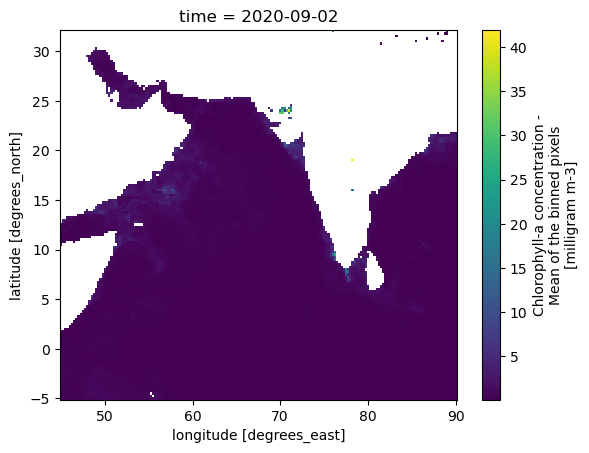

In [9]:
p = zarr_CHL.sel(time='2020-09-02').CHL.plot(y='lat', x='lon')

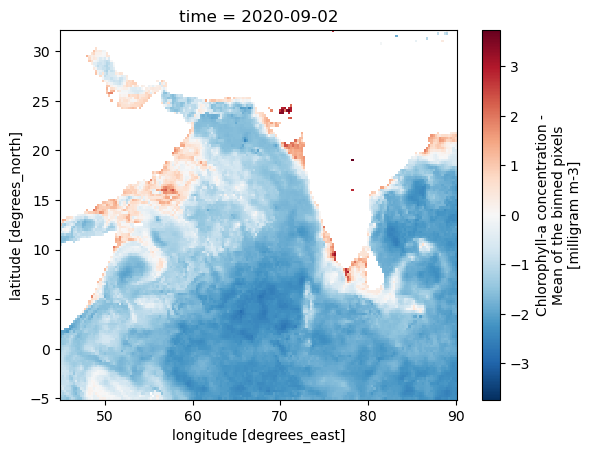

In [10]:
# log scale
np.log(zarr_CHL.sel(time='2020-09-02').CHL).plot(y='lat', x='lon')

In [6]:
# xr.merge((zarr_CHL.CHL, zarr_CHL.sst))
zarr_test = zarr_CHL.copy()
zarr_test['CHL'] = np.log(zarr_CHL.CHL).copy()
# zarr_test
zarr_test.CHL[0].compute() - zarr_CHL.CHL[0].compute()
shape = (100, ) + zarr_test.CHL.shape[1:]
# xr.array(zarr_test.CHL, chunks=shape)
zarr_test.sel(time=slice('2020-01-01', '2020-9-30'))
zarr_test['CHL'] = (('time', 'lat', 'lon'), da.where(da.isnan(zarr_CHL.CHL), 10E-10, zarr_CHL.CHL))
a = ['1', 'b']
a+['c']

['1', 'b', 'c']

In [7]:
zarr_CHL.CHL_uncertainty.max().compute()


<xarray.DataArray 'CHL_uncertainty' ()> Size: 4B
array(127.318726, dtype=float32)

## Process the data

We need to split into our training and testing data.

In [11]:
def log_label(data, label):
    data_logged = data.copy()
    data_logged[label] = np.log(data[label]).copy()
    return data_logged

# Add more preprocessing later
def preprocess_data(data, features, label):
    # sel_data = data[features + label]
    # sel_data = da.where(da.isnan(sel_data), 0.0, sel_data)
    data_logged = log_label(data, label)

    sel_data_list = []
    for var in (features + [label]):
        sel_var_data = data_logged[var]
        sel_var_data = da.where(da.isnan(sel_var_data), 0.0, sel_var_data)
        sel_data_list.append(sel_var_data)
        # print(data[var]).shape
    # sel_data_da = da.from_array(sel_data_arr)
    # sel_data = da.where(da.isnan(sel_data_da), 0.0, sel_data_da)
    sel_data_da =  da.array(sel_data_list)
    # sel_data_da = np.moveaxis(sel_data_da, 0, -1)
    return sel_data_da

def time_series_split(data, split_ratio):
    X = data[:-1]
    y = data[-1]
    
    X = np.moveaxis(X, 0, -1)

    total_length = X.shape[0]
    
    train_end = int(total_length * split_ratio[0])
    val_end = int(total_length * (split_ratio[0] + split_ratio[1]))

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end: val_end], y[train_end: val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    return (X_train, y_train,
            X_val, y_val,
            X_test, y_test)


Here we create our training and test data with 2 variables using only 2020. 70% data for training, 20% for validation and 10% for testing.

In [13]:
 # Curr Features: Sea Surface Temp (K), Sea Salinity Concentration (m**-3 or PSL). [Excluding Topography/Bathymetry (m)]
features = ['sst', 'so'] 
label = 'CHL_cmes-level3'  # chlorophyll-a concentration (mg/m**3) [Not taking uncertainty into consideration for now]
model_data = preprocess_data(zarr_CHL, features, label)

split_ratio = [.7, .2, .1]
X_train, y_train, X_val, y_val, X_test, y_test = time_series_split(model_data, split_ratio)

## Create the CNN model

In [14]:
def create_model_CNN(input_shape=(149, 181, 2)):
    model = Sequential()
    
    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     input_shape=input_shape, 
                     padding='same',
                     activation='relu'
                     ))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     padding='same',
                     activation='relu'
                     ))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=1, 
                     kernel_size=(3, 3), 
                     padding='same', 
                     activation='linear'
                     ))
    
    return model

model = create_model_CNN()
model.summary()

/srv/conda/envs/notebook/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-08-21 01:18:29.632682: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-21 01:18:29.632981: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/tes

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 149, 181, 64)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 149, 181, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 149, 181, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 149, 181, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 149, 181, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 149, 181, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 149, 181, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,353 (79.50 KB)

 Trainable params: 20,161 (78.75 KB)

 Non-trainable params: 192 (768.00 B)

In [15]:
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(8)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(8)

history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[early_stop])

Epoch 1/50


2024-08-21 01:19:14.976264: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-21 01:19:15.167716: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 1.1156 - mae: 1.1156 - val_loss: 1.0242 - val_mae: 1.0242
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8378 - mae: 0.8378 - val_loss: 0.6492 - val_mae: 0.6492
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7707 - mae: 0.7707 - val_loss: 0.5647 - val_mae: 0.5647
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7562 - mae: 0.7562 - val_loss: 0.5580 - val_mae: 0.5580
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7154 - mae: 0.7154 - val_loss: 0.5441 - val_mae: 0.5441
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6769 - mae: 0.6769 - val_loss: 0.5646 - val_mae: 0.5646
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6749 - mae: 0.6749 - val_loss: 0.5613 - val_mae: 0.5613
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6768 - mae: 0.6768 - val_loss: 0.5505 - val_mae: 0.5505
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6273 - mae: 0.

## Plot training & validation loss values

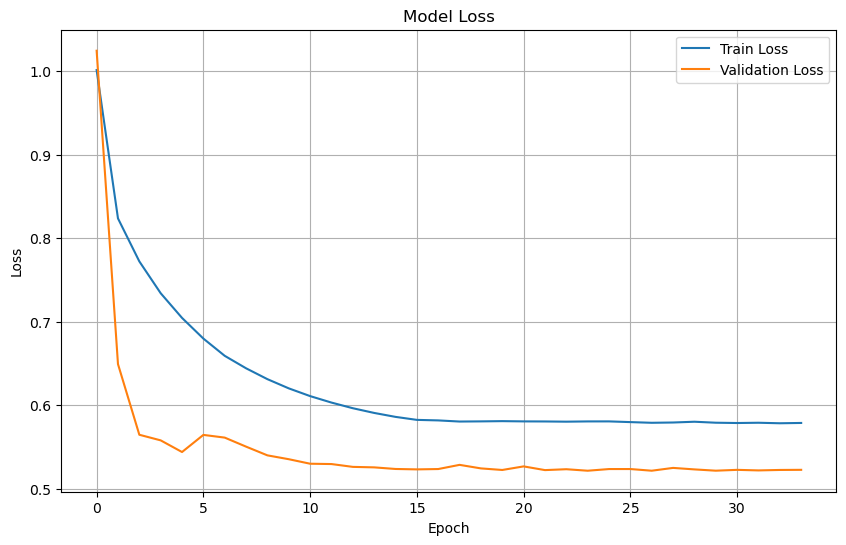

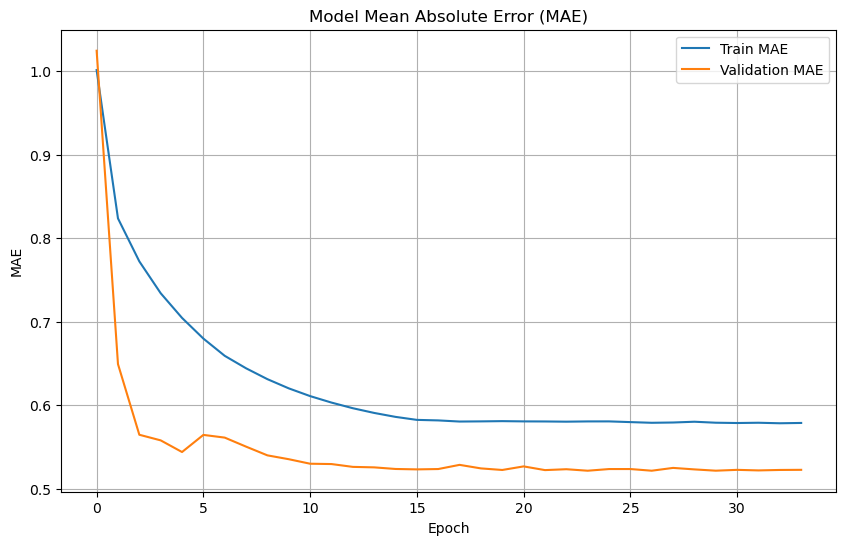

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## Prepare test dataset

In [17]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(4)

# Evaluate the model on the test dataset
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6469 - mae: 0.6469  
Test Loss: 0.6140401363372803
Test MAE: 0.6140401363372803


1/1 [==============================] - 0s 9ms/step


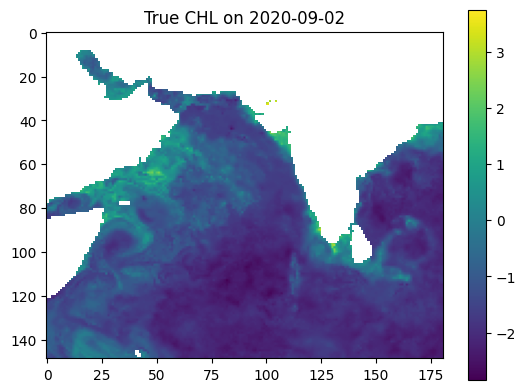

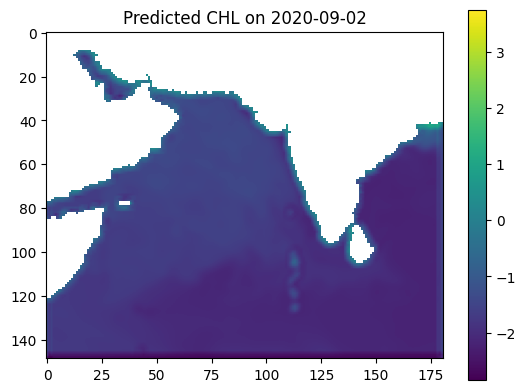

In [65]:
date_to_predict = '2020-09-02'
date_index = (np.datetime64(date_to_predict) - np.datetime64('2020-01-01')).item().days
true_output = np.log(zarr_CHL.sel(time=date_to_predict).CHL)
input = np.moveaxis(model_data[:-1], 0, -1)[date_index]
input = np.array(input)
predicted_output = model.predict(input[np.newaxis, ...])[0]

predicted_output = predicted_output[:,:,0]

land_mask = np.load(r"E:\24SU Varanasi Intern\参考资料\2023_Intern_Material\land_mask_nc.npy")
predicted_output[land_mask] = np.nan

# true_output_2 = (model_data[-1])[date_index]

vmax = np.nanmax((true_output, predicted_output))
vmin = np.nanmin((true_output, predicted_output))

plt.imshow(true_output, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f'True CHL on {date_to_predict}')
plt.show()




plt.imshow(predicted_output, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f'Predicted CHL on {date_to_predict}')
plt.show()



In [66]:
def compute_mae(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.mean(np.abs(y_true[mask] - y_pred[mask]))


predicted_mae = compute_mae(np.array(true_output), predicted_output)
print(f"MAE between Predicted Output and True Output: {predicted_mae}")

# last_input_frame = input_data[-1]
# last_input_frame_2d = np.squeeze(last_input_frame)
# true_output_2d = np.squeeze(true_output)
# last_frame_mae = compute_mae(true_output_2d, last_input_frame_2d)
# print(f"MAE between Last Input Frame and True Output: {last_frame_mae}")

MAE between Predicted Output and True Output: 0.5261644721031189


In [31]:
# (np.datetime64('2020-01-03') - np.datetime64('2020-01-01')) / np.timedelta64(1, 'D')
(np.datetime64('2020-01-03') - np.datetime64('2020-01-01')).item().days

2